# ETH/USD Prediction with ARIMA

##Data Collection

In [ ]:
import yfinance as yf
import pandas as pd

In [ ]:
# Download ETH/USDT price data
eth_data = yf.download('ETH-USD', start='2020-01-01', end='2024-12-31', interval='1d')
eth_data = eth_data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 'adj_close', 'Volume': 'volume'})
eth_data.dropna(inplace=True)
eth_data.index = pd.to_datetime(eth_data.index)
eth_data.to_csv('eth_usdt_data.csv')

[*********************100%***********************]  1 of 1 completed


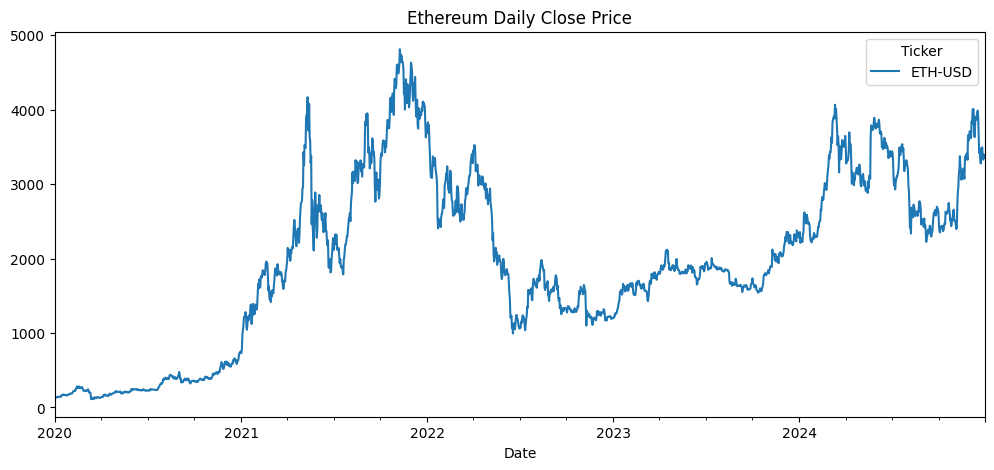

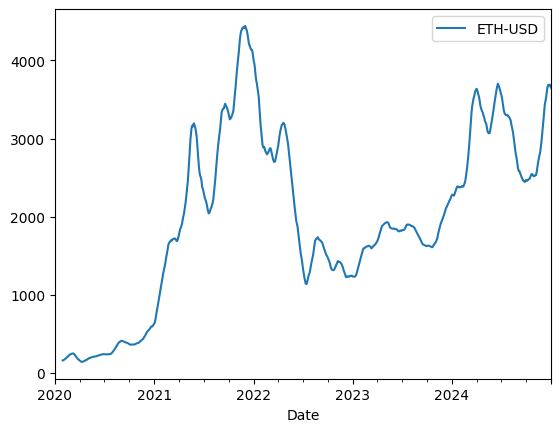

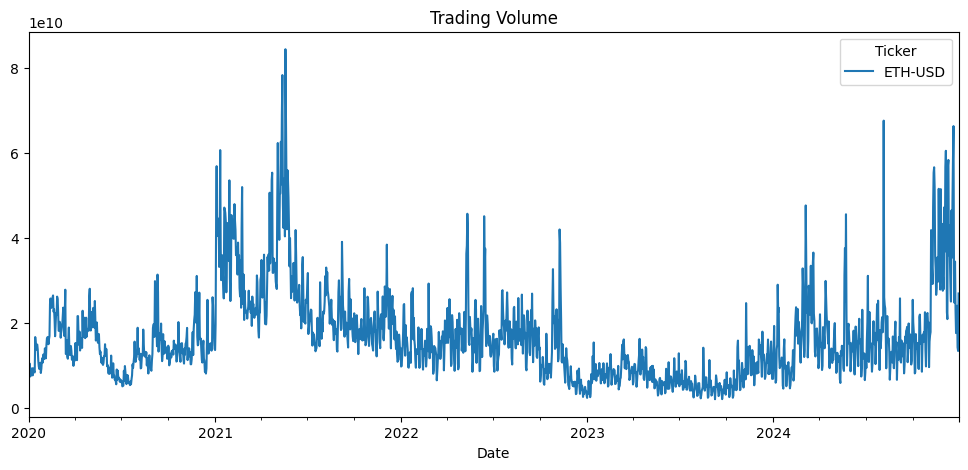

In [ ]:
import matplotlib.pyplot as plt

eth_data['close'].plot(figsize=(12, 5), title='Ethereum Daily Close Price')
eth_data['close'].rolling(window=30).mean().plot(label='30-day MA')
plt.legend()
plt.show()

eth_data['volume'].plot(figsize=(12, 5), title='Trading Volume')
plt.show()


In [ ]:
print(eth_data.describe())


Price         close         high          low         open        volume
Ticker      ETH-USD      ETH-USD      ETH-USD      ETH-USD       ETH-USD
count   1826.000000  1826.000000  1826.000000  1826.000000  1.826000e+03
mean    1981.600074  2033.090281  1922.570778  1980.032840  1.669406e+10
std     1147.276465  1178.978113  1112.597634  1148.003150  1.053916e+10
min      110.605873   116.021622    95.184303   110.406784  2.081626e+09
25%     1251.954102  1281.565033  1211.789398  1250.664185  9.452774e+09
50%     1870.897217  1904.886841  1839.892151  1869.789124  1.459358e+10
75%     2894.424500  2961.298218  2786.070618  2890.993103  2.059002e+10
max     4812.087402  4891.704590  4718.039062  4810.071289  8.448291e+10


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(eth_data['close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -1.9388719525648033
p-value: 0.31400116530566735


<Axes: title={'center': 'Differenced Close Price'}, xlabel='Date'>

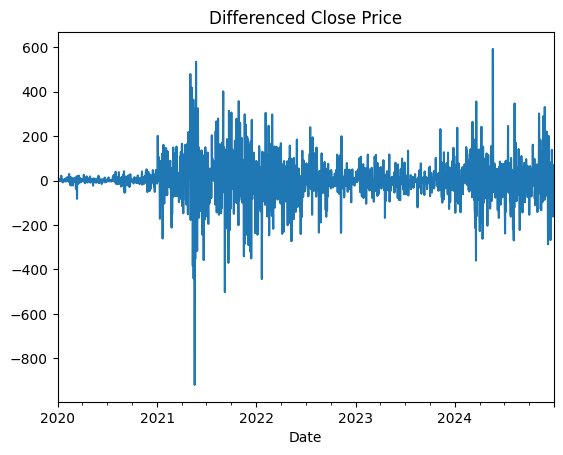

In [ ]:
eth_data['close_diff'] = eth_data['close'].diff().dropna()
eth_data['close_diff'].plot(title='Differenced Close Price')

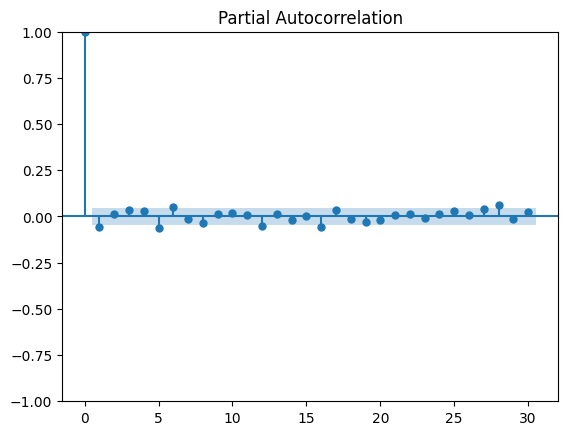

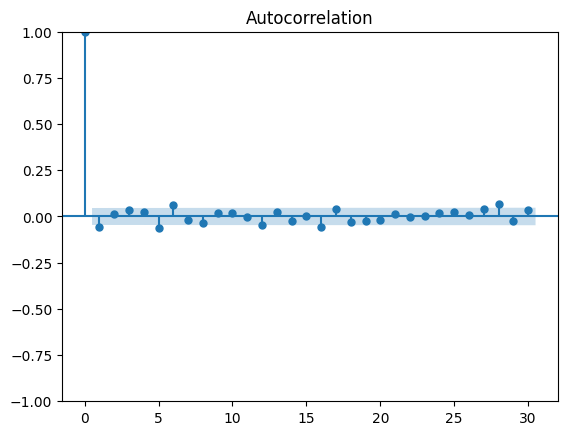

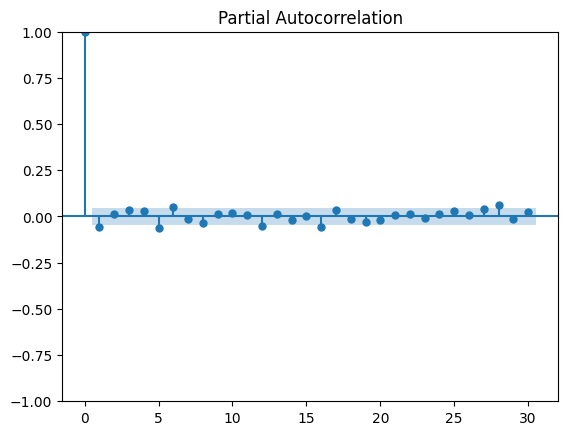

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(eth_data['close_diff'].dropna(), lags=30)
plot_pacf(eth_data['close_diff'].dropna(), lags=30)


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(eth_data['close'], order=(5,1,2))
model_fit = model.fit()
print(model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                ETH-USD   No. Observations:                 1826
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -10850.388
Date:                Wed, 21 May 2025   AIC                          21716.777
Time:                        18:40:59   BIC                          21760.851
Sample:                    01-01-2020   HQIC                         21733.035
                         - 12-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8152      0.211     -3.857      0.000      -1.229      -0.401
ar.L2         -0.4295      0.169     -2.539      0.011      -0.761      -0.098
ar.L3          0.0284      0.024      1.174      0.2

<Axes: xlabel='Date'>

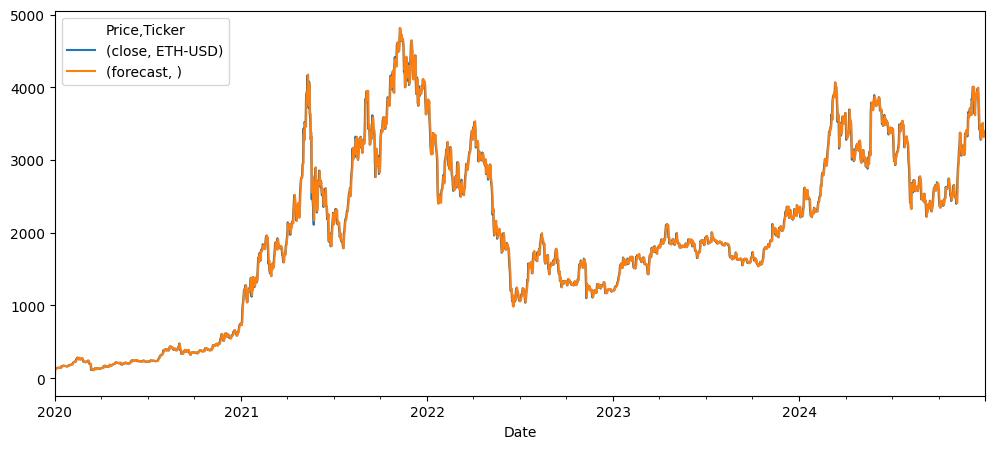

In [ ]:
eth_data['forecast'] = model_fit.predict(start=eth_data.index[0], end=eth_data.index[-1], dynamic=False)
eth_data[['close', 'forecast']].plot(figsize=(12, 5))

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

rmse = np.sqrt(mean_squared_error(eth_data['close'].iloc[1:], eth_data['forecast'].iloc[1:]))
mape = mean_absolute_percentage_error(eth_data['close'].iloc[1:], eth_data['forecast'].iloc[1:])
print(f'RMSE: {rmse:.2f}, MAPE: {mape:.2%}')


RMSE: 92.43, MAPE: 2.96%


<Axes: title={'center': 'Residuals'}, xlabel='Date'>

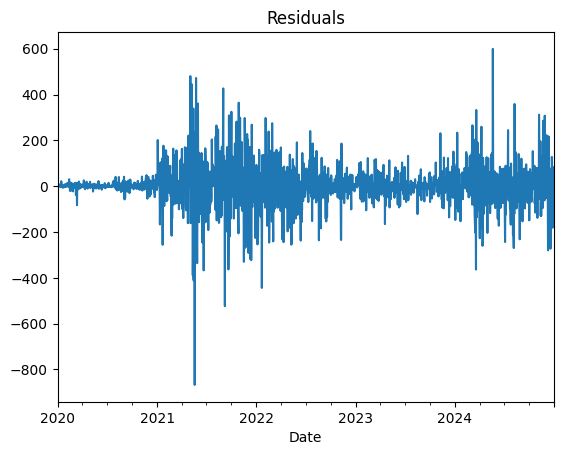

In [ ]:
residuals = model_fit.resid
residuals.plot(title="Residuals")


<Figure size 1200x500 with 0 Axes>

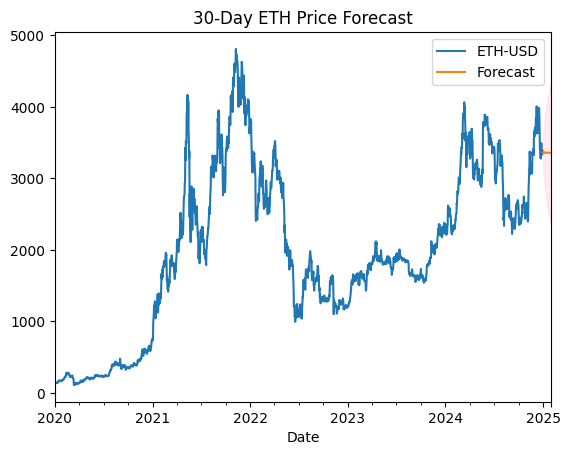

In [ ]:
forecast = model_fit.get_forecast(steps=30)
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 5))
eth_data['close'].plot(label='Past')
forecast.predicted_mean.plot(label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('30-Day ETH Price Forecast')
plt.show()
